<a href="https://colab.research.google.com/github/sayan0506/Capsule-Network-Implementation/blob/main/Capsule_Network_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing Capsule Network using Tensorflow**

Installing Dependencies

In [1]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

     |████████████████████████████████| 2.1MB 6.0MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 163kB 41.8MB/s 
     |████████████████████████████████| 133kB 36.8MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=ac0f29f2d22afd53f4666979ba4e567421e6648e648c7b8b4951077fc88d3781
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=846338b3c2e7755a9320d7e8d257bfadf9768465b122c4afb729ef8c3157abcf
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


## Import Dependencies

In [23]:
import random
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import seaborn as sns
from tqdm import tqdm

## Environment Setup

**Improve Reproducibility**

In [3]:
# improve reproducibility and make the implementation more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 - 1)

**Setup wandb(Weights  and Biases) environment**

In [4]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

## **Load Standard MNIST Dataset using Keras**

[MNIST Reference](https://keras.io/api/datasets/mnist/#load_data-function)

In [6]:
# load mnist by using standard train_test_split
(x_train, y_train), (x_test, y_test) = mnist.load_data(path = "mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


## **Data Inspection on MNIST**

In [8]:
print(f'Train input shape {x_train.shape}')
print(f'Train input shape {y_train.shape}')
print(f'Test input shape {x_test.shape}')
print(f'Test label shape {y_test.shape}')

Train input shape (60000, 28, 28)
Train input shape (60000,)
Test input shape (10000, 28, 28)
Test label shape (10000,)


# **Analyzing train and test distribution**

In [10]:
# dataframe for train distribution
train_df = pd.DataFrame(y_train, columns = ['Targets'])

# dataframe for test distribution
test_df = pd.DataFrame(y_test, columns = ['Targets'])

# train and test value counts
train_c = train_df.value_counts()
test_c = test_df.value_counts()

In [11]:
# class ids
class_ids = [i for i in range(10)]
print(f'Class ids {class_ids}')

Class ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### **Visualize the distribution for train and test set**


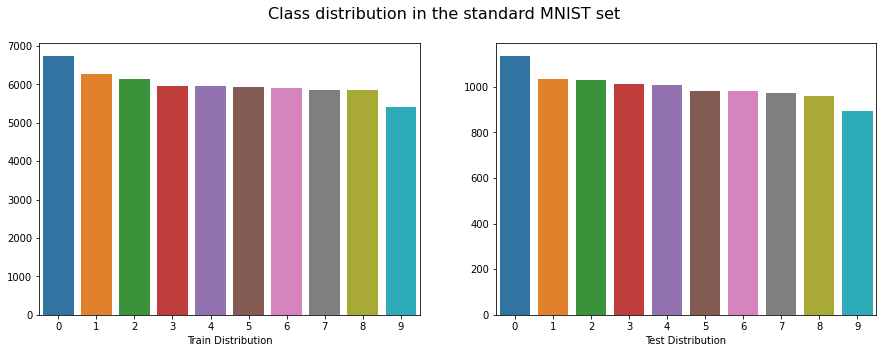

In [14]:
fig = plt.figure(figsize = (15,5))
fig.suptitle('Class distribution in the standard MNIST set', fontsize = 16)
fig.tight_layout()

# train distribution
fig.add_subplot(121)
sns.barplot(x = class_ids, y = train_c.values)
plt.xlabel('Train Distribution')

# test distribution
fig.add_subplot(122)
sns.barplot(x = class_ids, y = test_c.values)
plt.xlabel('Test Distribution')

plt.show()

We can see both train and test data are stratified split

#### **Sample Visualization of MNIST samples for individual Classes**

Picking random sample of each class from train set and visualize  

In [17]:

def mnist_vis(x_train, y_train, class_ids):
  '''
  Visualize random MNIST samples
  '''
  index_list = [random.choice([j for j,label in enumerate(y_train) if label==i])
   for i in class_ids]
  
  # obtaining sample images from train set
  sample_img = [x_train[index] for index in index_list]
  
  rows = 2
  cols = int(len(index_list)/rows)

  fig = plt.figure(figsize = (15,5))
  fig.suptitle('MNISt samples visualization', fontsize = 16)
  #fig.tight_layout()
  
  for a,idx in enumerate(index_list):
    fig.add_subplot(rows, cols, a+1)
    plt.imshow(x_train[idx], cmap = 'gray')
    plt.xlabel(f'Label: {a}')
    plt.xticks([])
    plt.yticks([])

  plt.show()

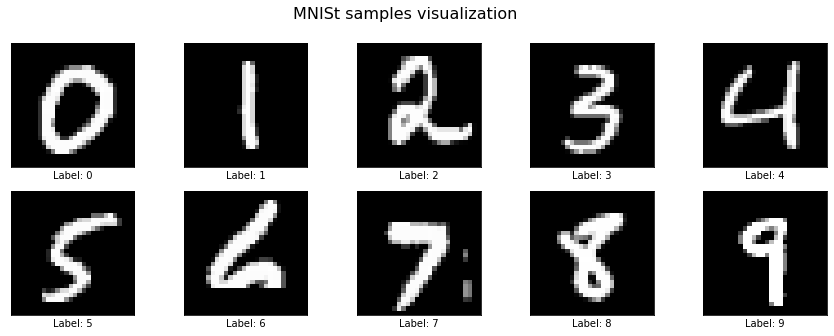

In [18]:
# calling visualization
mnist_vis(x_train, y_train, class_ids)

## **Data Preperation MNIST**
Data preprocessing steps include

1. Converting image pixels to float32
2. Normalizing the pixels
3. Reshaping

In [20]:
def mnist_prep(x_train, x_test):
  # convert images pixel to standard float32
  x_train_norm = tf.cast(x_train, dtype = tf.float32)
  x_test_norm = tf.cast(x_test, dtype = tf.float32)
  
  # normalize pixels
  x_train_norm = x_train_norm/255.0
  x_test_norm = x_test_norm/255.0

  # reshape the data (m, nh, nw, nc) nc = 1
  x_train = tf.expand_dims(x_train_norm, axis = -1)
  x_test = tf.expand_dims(x_test_norm, axis = -1)

  return x_train, x_test

In [21]:
# loading pre-processes data
x_train_pro, x_test_pro = mnist_prep(x_train, x_test)

print(f'Preprocessed train input shape {x_train_pro.shape}')
print(f'Preprocessed test input shape {x_test_pro.shape}')

Preprocessed train input shape (60000, 28, 28, 1)
Preprocessed test input shape (10000, 28, 28, 1)


#### **Evaluating the pre-processing steps**

In [22]:
# both the input image format are same or not
assert x_train_pro.shape[1:] == x_test_pro.shape[1:]
# checking lenghth of input and label
assert x_train_pro.shape[0] == y_train.shape[0] and x_test_pro.shape[0] == y_test.shape[0]
# checking image data type
assert x_train_pro.dtype == x_test_pro.dtype

print("All assertion test cases passed")

All assertion test cases passed
